In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
# from xgboost.sklearn import XGBClassifier
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('train.csv')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,low_normal,0.0,1.0,1.0,0.0,-606.0,179055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,0.000,0.000000,0.0,0.0,0.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,low_normal,1.0,1.0,1.0,-135882.0,-828.0,348637.5,-746.0,1035882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-536.0,0.000,0.000000,0.0,0.0,0.0,-23.0,0.0,0.0,-66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,middle,0.0,1.0,1.0,4176.0,-815.0,20106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-724.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,0.0,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,XNA,0.0,1.0,1.0,0.0,-311.0,267930.0,-181.0,675000.0,-181.0,270000.0,-1.0,0.0,-2.0,0.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.0,-11.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,0.0,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,middle,1.0,1.0,1.0,-26788.5,-1768.0,30663.0,-374.0,274288.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,29857.365,452.384318,0.0,16.0,0.0,-3.0,0.0,0.0,-9.0,0.0,0.0,-10.0,0.0,0.0,-35.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,22

In [4]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            # print("******************************")
            # print("Column: ",col)
            # print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            # print("dtype after: ",props[col].dtype)
            # print("******************************")
    
    # Print final result
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props    

In [5]:
# train = reduce_mem_usage(train)
train = train.sample(frac=1)
train = train[:40000]

Memory usage of properties dataframe is : 537.2622299194336  MB
Memory usage is:  215.84341430664062  MB
This is  40.17468608187996 % of the initial size


In [6]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AMT_DOWN_PAYMENT,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
SK_ID_CURR,1.000000,0.000073,-0.002696,-0.003986,-0.000494,0.000652,0.000257,0.003765,-0.003382,0.001006,-0.001510,-0.002519,0.001581,NaN,-0.001013,0.004561,0.001893,0.006491,0.003356,-0.004094,-0.002848,-0.004228,0.004379,0.002843,0.009519,0.010884,-0.005610,-0.003959,-0.001485,-0.002659,0.004078,0.000107,0.000040,-0.001989,0.000977,0.000979,-0.001624,0.001387,-0.002885,0.002820,...,0.002073,-0.000669,0.001976,0.003031,-0.003699,-0.002698,0.001423,-0.000783,0.002653,0.001116,0.001044,-0.001483,0.001105,-0.001549,0.003602,-0.002580,-0.000310,-0.000544,0.000824,-0.004777,-0.001587,0.000174,0.000084,-0.002044,-0.001615,0.001204,0.006538,-0.001106,-0.006441,0.001485,-0.001057,-0.001883,-0.001606,0.002464,-0.004055,0.000520,0.005424,-0.000932,-0.001850,0.005441
TARGET,0.000073,1.000000,0.019941,0.002330,-0.030228,-0.013559,-0.039605,-0.034379,0.079237,-0.046786,0.042218,0.055922,0.001977,NaN,0.047860,0.026437,-0.000798,-0.026292,-0.007626,0.010038,0.057963,0.061232,-0.025101,0.007221,0.010382,0.005130,0.043671,0.052994,0.033770,-0.062597,-0.158793,-0.115252,-0.038863,-0.032815,-0.041067,-0.033804,-0.018819,-0.034626,-0.035660,-0.049395,...,-0.017920,-0.000940,0.014285,0.015310,-0.000638,0.007819,-0.031765,0.011962,-0.016056,0.006899,0.000800,-0.010132,0.014802,-0.007197,0.014412,-0.001112,0.009431,0.003130,0.006401,0.008533,0.020491,0.007077,-0.005959,0.026210,0.030436,0.007672,0.029133,0.042982,0.012798,0.000760,0.020708,0.019087,0.001218,0.017805,0.023489,-0.000991,0.012238,0.018794,-0.000011,0.002797
CNT_CHILDREN,-0.002696,0.019941,1.000000,0.010246,0.002140,0.022257,-0.001928,-0.027264,0.329653,-0.240204,0.183231,-0.027684,0.065457,NaN,0.241085,0.056923,0.003094,-0.028369,0.027371,0.878416,0.024606,0.025212,-0.004205,-0.009530,0.008771,0.014050,0.020596,0.070681,0.070054,0.055599,-0.020798,-0.009540,-0.031612,-0.027264,-0.036335,-0.022699,-0.011020,-0.021072,-0.031505,-0.032469,...,0.013463,-0.039318,0.020328,0.030425,0.026876,0.032323,-0.002857,0.037642,-0.045458,0.003697,-0.002036,0.000224,-0.000152,0.005440,-0.002197,0.009160,0.001326,0.010651,-0.006637,0.001815,0.006110,-0.011429,-0.013170,0.009946,0.010303,0.002490,-0.001263,0.009259,-0.039409,-0.002002,0.004897,-0.036799,-0.001419,0.004972,-0.021117,-0.003173,0.004443,-0.009251,-0.003969,0.008786
AMT_INCOME_TOTAL,-0.003986,0.002330,0.010246,1.000000,0.104307,0.126906,0.105957,0.048731,0.020072,-0.043060,0.018034,0.005780,0.013191,NaN,0.042899,-0.014518,-0.006599,-0.000705,0.025894,0.012622,-0.057637,-0.061862,0.025754,0.021030,0.041810,0.039295,0.000942,0.002740,0.004243,0.027612,0.036365,0.000008,0.038925,0.031042,0.0355

In [7]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'STATUS_0']

In [8]:
train = train.drop(to_drop, axis=1)

In [9]:
train['OCCUPATION_TYPE'].value_counts()/len(train) 
train['OCCUPATION_TYPE'].unique()
train['OCCUPATION_TYPE'].replace([ 'Cleaning staff', 'Cooking staff', 'Accountants', 'Medicine staff'
        'Private service staff', 'Security staff','Waiters/barmen staff',
        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff'], 'Others', inplace= True)
train['ORGANIZATION_TYPE'].value_counts()/len(train) 
train['ORGANIZATION_TYPE'].replace(['School', 'Religion',
       'Other','Electricity', 'Medicine',
       'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry: type 8', 'Realtor', 'Industry: type 6'], 'Others', inplace = True)
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.919425
1    0.080575
Name: TARGET, dtype: float64

In [10]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [11]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [12]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_2                  -0.158793
EXT_SOURCE_3                  -0.115252
EXT_SOURCE_1                  -0.062597
Days_employed_age             -0.054957
FLOORSMAX_AVG                 -0.049395
YEARS_BEGINEXPLUATATION_AVG   -0.041067
ratio_approved                -0.041020
TOTALAREA_MODE                -0.039264
LIVINGAREA_AVG                -0.038989
APARTMENTS_AVG                -0.038863
Name: TARGET, dtype: float64

In [13]:
corr.tail(10)

REG_CITY_NOT_WORK_CITY         0.052994
DAYS_ID_PUBLISH                0.055922
DAYS_LAST_PHONE_CHANGE         0.055978
REGION_RATING_CLIENT           0.057963
REGION_RATING_CLIENT_W_CITY    0.061232
DAYS_EMPLOYED                  0.069608
ratio_refused                  0.074375
DAYS_BIRTH                     0.079237
TARGET                         1.000000
FLAG_MOBIL                          NaN
Name: TARGET, dtype: float64

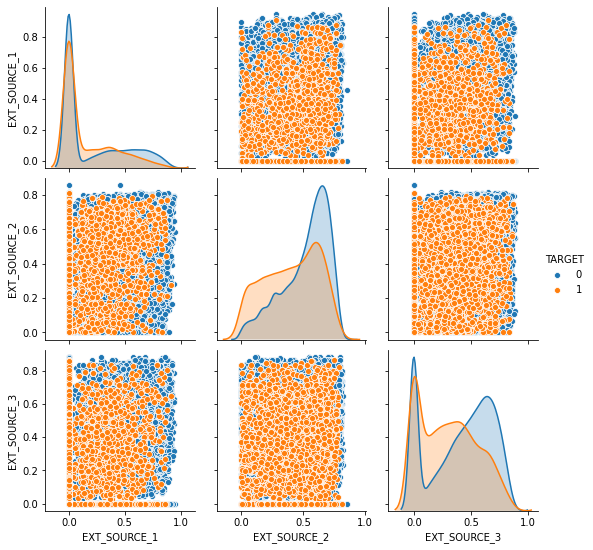

In [14]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

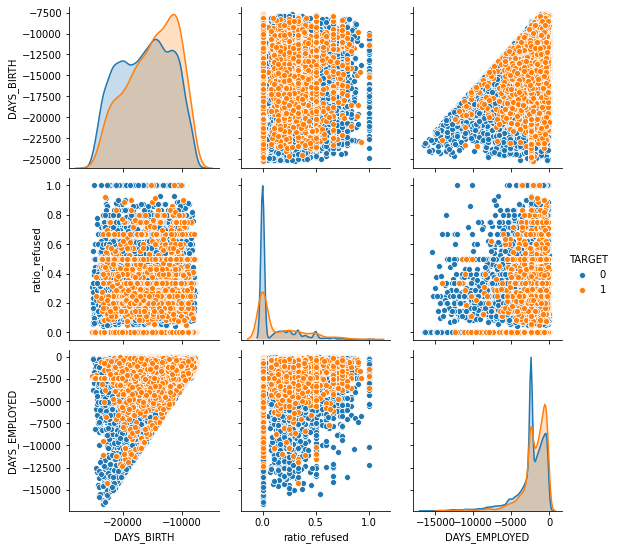

In [15]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [16]:
# # Polynomial Features
# from sklearn.preprocessing import PolynomialFeatures
# poly_transformer = PolynomialFeatures(degree = 3)
# pfeatures = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused']] 
# poly_features = poly_transformer.fit_transform(pfeatures)
# names = poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused'])
# poly_features = pd.DataFrame(poly_features, columns = names)
# poly_features['SK_ID_CURR'] = train['SK_ID_CURR'].values
# train = train.merge(poly_features, on='SK_ID_CURR', how= 'left')
# train


In [17]:
train = pd.get_dummies(train, drop_first=True)

In [18]:
train['TARGET'].value_counts()/len(train)

0    0.919425
1    0.080575
Name: TARGET, dtype: float64

In [19]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [20]:
# sc = StandardScaler()
# X_pca = sc.fit_transform(X)
# pca = PCA(n_components = 175)
# X_pca = pca.fit_transform(X_pca)
# sum(pca.explained_variance_ratio_)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=1234)
pipeline = make_pipeline(StandardScaler(),   XGBClassifier()) # PCA(n_components = 175),
params = {
    'xgbclassifier__learning_rate': [0.1], #[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    'xgbclassifier__max_depth': [5], #[3, 4, 5, 6, 8, 10, 12, 15],
    'xgbclassifier__min_child_weight': [7], #[1, 3, 5, 7, 9, 11] "stop trying to split once your sample size in a node goes below a given threshold".
    'xgbclassifier__gamma' : [0.2], #[0, 0.1, 0.2, 0.3], minimum loss reduction required to make a split.
    'xgbclassifier__colsample_bytree':  [0.3], #[0.3, 0.5, 0.7, 1]           
}
model = RandomizedSearchCV(pipeline, params, n_iter=1, scoring='roc_auc', cv=5, n_jobs=-1, verbose = 3)
model.fit(X_train, y_train)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


0.7666517195011777

In [22]:
model.best_params_

{'xgbclassifier__colsample_bytree': 0.3,
 'xgbclassifier__gamma': 0.2,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__min_child_weight': 7}

In [23]:
from sklearn.metrics import accuracy_score
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] 
print('XGBoost AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)
# print( 'XGBoost accuracy:', accuracy_score(y_test, pred_class))

XGBoost AUC 0.7599394743421923


In [24]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [25]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# print( confusion_matrix(y_test, pred_class) )
# cm = confusion_matrix(y_test, pred_class)
pred_class_2 = (np.array(pred) > 0.1).astype(int)
print(confusion_matrix(y_test, pred_class_2))
cm = confusion_matrix(y_test, pred_class_2)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[17239  4836]
 [  785  1140]]
Precision: 0.19076305220883535
Recall 0.5922077922077922


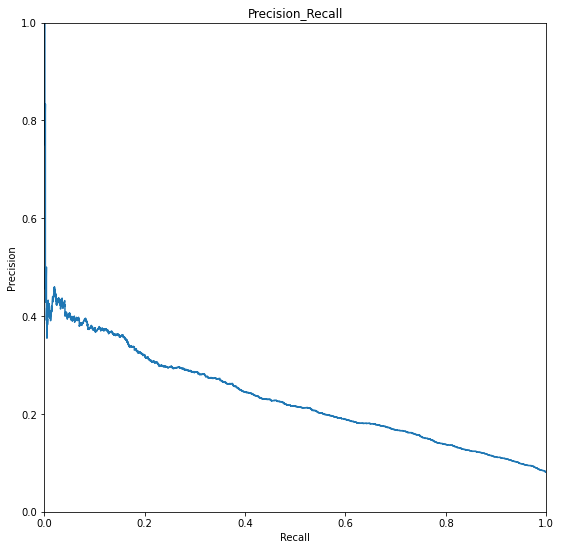

In [26]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [27]:
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,1.752841
1,1.000000,0.000519,inf,0.752841
2,1.000000,0.001558,inf,0.677997
3,0.971753,0.001558,4.543333e+04,0.656626
4,0.982858,0.002597,4.492000e+04,0.630789
...,...,...,...,...
3273,0.504093,0.998961,4.037205e+00,0.011111
3274,0.504223,0.999481,4.036164e+00,0.011092
3275,0.502775,0.999481,4.024413e+00,0.010062
3276,0.502905,1.000000,4.023373e+00,0.010046


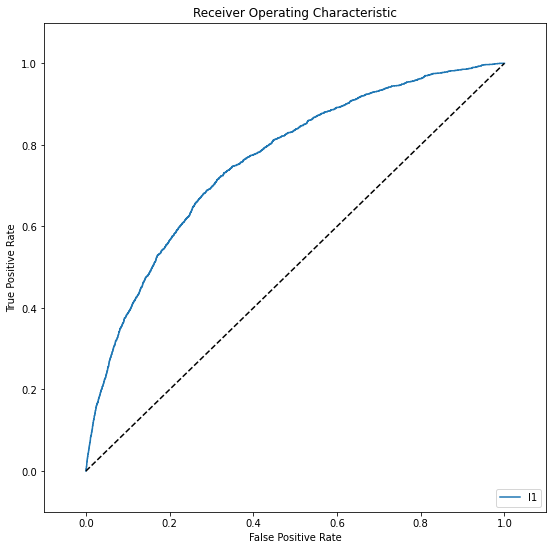

In [28]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# AUROC
roc_auc_score(y_test, pred)

0.7599394743421923

In [30]:
pred_class_v2 = (np.array(pred) > 0.2).astype(int)
cohen_kappa = cohen_kappa_score(y_test, pred_class_v2)
cohen_kappa

0.21753278585780622